# BT4012 Fraud Analytics Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import networkx as nx
from datetime import datetime
from sklearn.model_selection import train_test_split
from scipy import stats

## Importing Data

In [5]:
old_train = pd.read_csv("fraudTrain.csv", index_col=0)
old_test = pd.read_csv("fraudTest.csv", index_col=0)

## Splitting to Train, Validate and Test

In [6]:
full_dataset = pd.concat([old_train, old_test]).reset_index(drop=True)

# # convert trans_date_trans_time into datetime object, add columns for hour of transaction and date of transaction
# full_dataset["transaction_dt"] = pd.to_datetime(full_dataset["trans_date_trans_time"])
# full_dataset["transaction_hour"] = full_dataset["transaction_dt"].dt.hour

train, intermediate = train_test_split(full_dataset, random_state=0, test_size=0.3)
test, valid = train_test_split(intermediate, random_state=0, test_size = 2/3)

In [4]:
train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
456136,2019-07-21 08:34:47,4025612008285111,"fraud_Langworth, Boehm and Gulgowski",shopping_net,3.30,Krystal,Key,F,23142 Montoya Island Apt. 742,Corsica,...,41.1762,-79.1976,1274,Maintenance engineer,1949-03-20,609a8c2791f637f3ac1aedc55911a6da,1342859687,40.903680,-79.606226,0
1786382,2020-12-17 07:03:16,4642894980163,"fraud_Greenholt, Jacobi and Gleason",gas_transport,56.06,Eddie,Mendez,M,1831 Faith View Suite 653,Clarinda,...,40.7491,-95.0380,7297,IT trainer,1990-07-13,42cae72b8ae6f099ba27038e4e3a7f6b,1387263796,40.576635,-95.328714,0
516133,2019-08-11 12:18:21,342952484382519,"fraud_Schiller, Blanda and Johnson",home,31.59,Kayla,Jones,F,6033 Young Track Suite 804,East Canaan,...,42.0158,-73.2913,647,Comptroller,1987-09-26,9932fc5175e5e996643106017f7837fa,1344687501,41.883074,-74.151101,0
1387558,2020-07-22 14:02:52,38199021865320,fraud_Cormier LLC,health_fitness,75.61,Jesse,Roberts,M,8415 Vaughn Squares Apt. 788,Acworth,...,43.1960,-72.3001,477,Naval architect,1988-04-15,9de51fb137c9b2e4dc3bf763ef3d2e4c,1374501772,42.554582,-71.888495,0
1105509,2020-04-05 09:29:27,676281772837,"fraud_Rowe, Batz and Goodwin",grocery_pos,78.80,Alicia,Bishop,F,222 Freeman Islands,Whigham,...,30.8836,-84.3246,3430,"Editor, commissioning",1950-03-25,4ac3dcb2533891924dc84eace661ce52,1365154167,30.126658,-84.274753,0


In [5]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 456136 to 305711
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop           

We can see that the data is all non-null and separate also the Categorical and Numerical columns

In [6]:
numerical_variables = ["cc_num", "amt", "zip", "lat", "long", "city_pop","unix_time", "merch_lat", "merch_long", "is_fraud"]
cat_variables = ["merchant", "category", "first", "last", "gender", "street", "city", "state", "job","dob","trans_num"] 
remaining_variable = ["trans_date"]

In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
cc_num,1296675.0,4.176007e+17,1.309380e+18,6.041621e+10,1.800429e+14,3.521417e+15,4.642255e+15,4.992346e+18
amt,1296675.0,7.008490e+01,1.628042e+02,1.000000e+00,9.630000e+00,4.741000e+01,8.304000e+01,2.894890e+04
zip,1296675.0,4.881636e+04,2.687663e+04,1.257000e+03,2.623700e+04,4.817400e+04,7.201100e+04,9.992100e+04
lat,1296675.0,3.854065e+01,5.070134e+00,2.002710e+01,3.466890e+01,3.935430e+01,4.194040e+01,6.669330e+01
long,1296675.0,-9.023144e+01,1.374897e+01,-1.656723e+02,-9.679800e+01,-8.747690e+01,-8.017520e+01,-6.795030e+01
city_pop,1296675.0,8.836546e+04,3.010802e+05,2.300000e+01,7.410000e+02,2.435000e+03,2.032800e+04,2.906700e+06
unix_time,1296675.0,1.358677e+09,1.820237e+07,1.325376e+09,1.342999e+09,1.357093e+09,1.374592e+09,1.388534e+09
merch_lat,1296675.0,3.854014e+01,5.104269e+00,1.902779e+01,3.474414e+01,3.936965e+01,4.195856e+01,6.751027e+01
merch_long,1296675.0,-9.023124e+01,1.376077e+01,-1.666712e+02,-9.690138e+01,-8.744308e+01,-8.024942e+01,-6.695090e+01
is_fraud,1296675.0,5.175545e-03,7.175488e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [8]:
unique_counts = {}
for variable in cat_variables:
    unique_count = full_dataset[variable].nunique()
    unique_counts[variable] = unique_count

# Output the count of unique values for each categorical variable
for variable, count in unique_counts.items():
    print(f"There are {count} unique values in the '{variable}' column.")

There are 693 unique values in the 'merchant' column.
There are 14 unique values in the 'category' column.
There are 355 unique values in the 'first' column.
There are 486 unique values in the 'last' column.
There are 2 unique values in the 'gender' column.
There are 999 unique values in the 'street' column.
There are 906 unique values in the 'city' column.
There are 51 unique values in the 'state' column.
There are 497 unique values in the 'job' column.
There are 984 unique values in the 'dob' column.
There are 1852394 unique values in the 'trans_num' column.


In [9]:
train["transaction_dt"] = pd.to_datetime(train["trans_date_trans_time"])
test["transaction_dt"] = pd.to_datetime(test["trans_date_trans_time"])
train["transaction_hour"] = train["transaction_dt"].dt.hour
test["transaction_hour"] = test["transaction_dt"].dt.hour
# Extract the day of the week (Monday=0, Sunday=6) and then convert to actual day names
train['transaction_day_of_week'] = train['transaction_dt'].dt.day_name()
test['transaction_day_of_week'] = test['transaction_dt'].dt.day_name()


#One-hot encoding to the 'transaction_day_of_week' and 'Categories)
# train = pd.get_dummies(train, columns=['transaction_day_of_week'], dtype=int)
# test = pd.get_dummies(test, columns=['transaction_day_of_week'], dtype=int)


# EDA

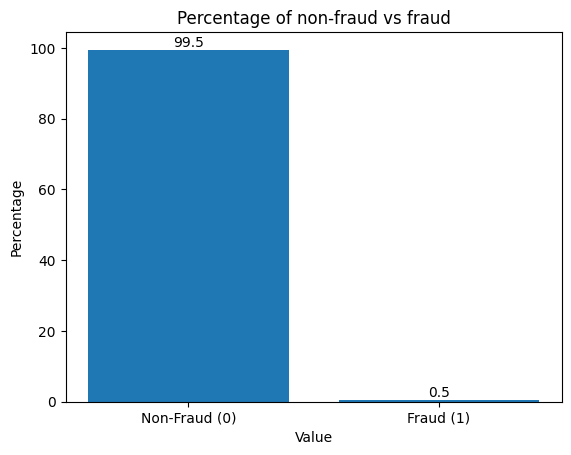

In [10]:
ratio = train["is_fraud"].value_counts() / len(train) *100
ratio

bar_plot = plt.bar(ratio.index, ratio.values)
plt.xlabel("Value")
plt.ylabel("Percentage")
plt.title("Percentage of non-fraud vs fraud")
plt.xticks(ratio.index, labels=["Non-Fraud (0)", "Fraud (1)"])

# Display the ratio on top of the bars
for bar, value in zip(bar_plot, ratio.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:.1f}", ha="center", va="bottom")

plt.show()

<Axes: xlabel='amt', ylabel='Density'>

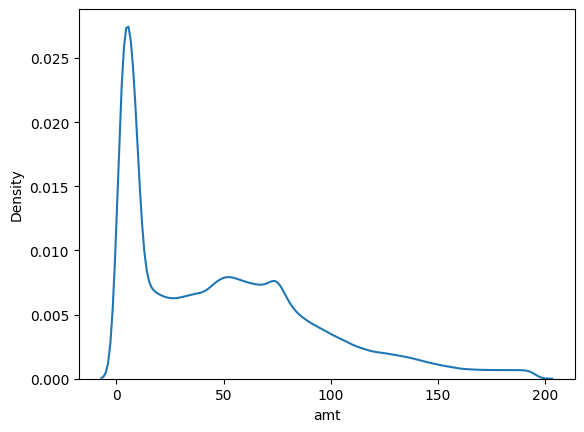

In [11]:
quantile_95 = train['amt'].quantile(0.95)
filtered_data = train[train['amt'] <= quantile_95]['amt']

sns.kdeplot(data=filtered_data)

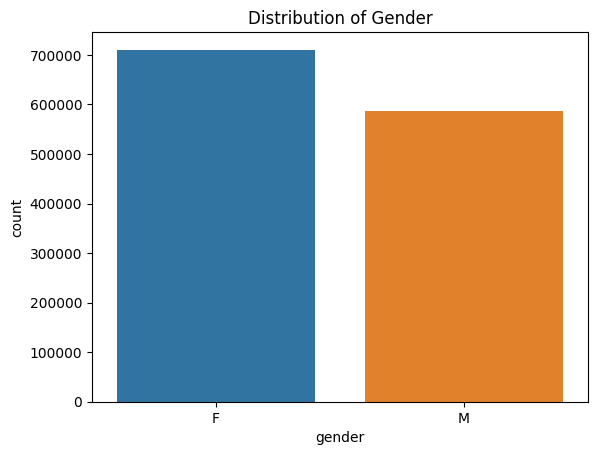

In [12]:
sns.countplot(data=train, x='gender')
plt.title('Distribution of Gender')
plt.show()

In [13]:
duplicates_count = train.duplicated(subset=["cc_num"]).sum()
print(f"total number duplicate users: {duplicates_count}")

total number duplicate users: 1295676


Text(0.5, 0.98, 'Age vs Fraud Class')

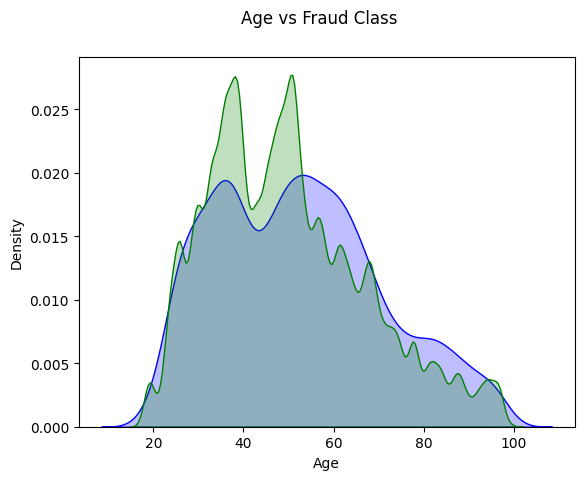

In [14]:
current_year = datetime.now().year
train['dob'] = pd.to_datetime(train['dob'])
train['age'] = current_year - train['dob'].dt.year
test['dob'] = pd.to_datetime(test['dob'])
test['age'] = current_year - test['dob'].dt.year


fig, ax = plt.subplots()

sns.kdeplot(train[train["is_fraud"]==1]["age"], fill=True, color="blue", label="Fraudulent", ax=ax)
sns.kdeplot(train[train["is_fraud"]==0]["age"], fill=True, color="green", label="Normal", ax=ax)

ax.set_xlabel("Age")
ax.set_ylabel("Density")

fig.suptitle("Age vs Fraud Class")

Text(0.5, 0.98, 'Amount vs Fraud Class')

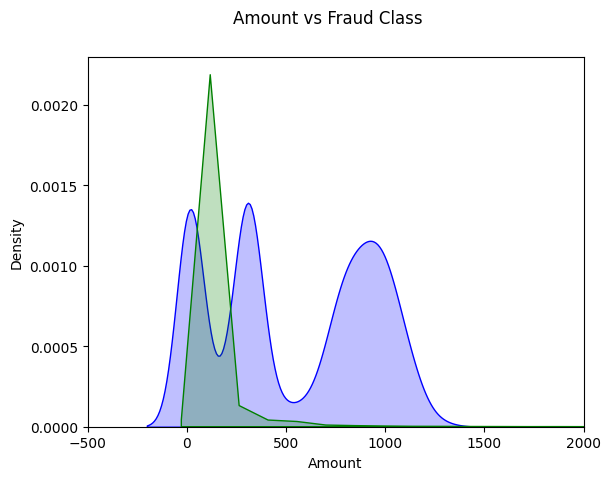

In [15]:
fig, ax = plt.subplots()

sns.kdeplot(train[train["is_fraud"]==1]["amt"], fill=True, color="blue", label="Fraudulent", ax=ax)
sns.kdeplot(train[train["is_fraud"]==0]["amt"], fill=True, color="green", label="Normal", ax=ax)

ax.set_xlabel("Amount")
ax.set_ylabel("Density")

ax.set_xlim(-500,2000)

fig.suptitle("Amount vs Fraud Class")

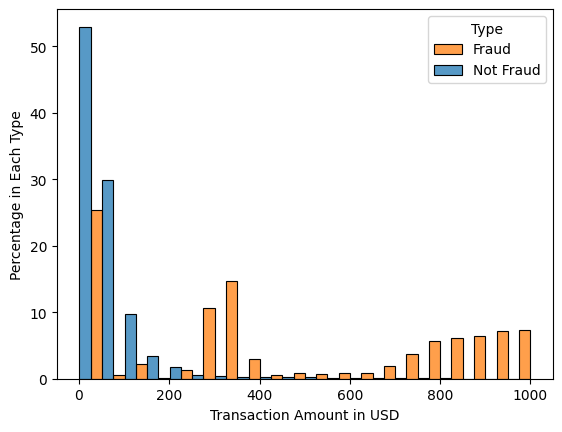

In [41]:
#Alternative to show amount vs fraud
ax=sns.histplot(x='amt',data=train[train.amt<=1000],hue='is_fraud',stat='percent',multiple='dodge',common_norm=False,bins=20)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount in USD')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

Typically, legitimate transactions are approximately $200 or lower, whereas fraudulent transactions often spike near $300 and again between $800 and $1000. This demonstrates a very distinct trend.

In [16]:
# fig, ax = plt.subplots()

# train['log_amt'] = np.log1p(train['amt']) # Use log(1+x) to handle cases where amount is 0
# sns.kdeplot(train[train["is_fraud"]==1]["log_amt"], fill=True, color="blue", label="Fraudulent", ax=ax)
# sns.kdeplot(train[train["is_fraud"]==0]["log_amt"], fill=True, color="green", label="Normal", ax=ax)
# ax.set_xlabel("Log(Amount)")
# ax.set_ylabel("Density")

# fig.suptitle("Amount vs Fraud Class")


From the above kernel density plot, we can see that the peak of the curve for fraudulent transactions is approximately around the value of 7 of the x-axis, whereas that of non-fraudulent transactions is approximately around the value of 4. It shows that fraudulent transactions are more likely to involve higher amounts as compared to non-fraudulent ones. 

<Axes: xlabel='is_fraud', ylabel='amt'>

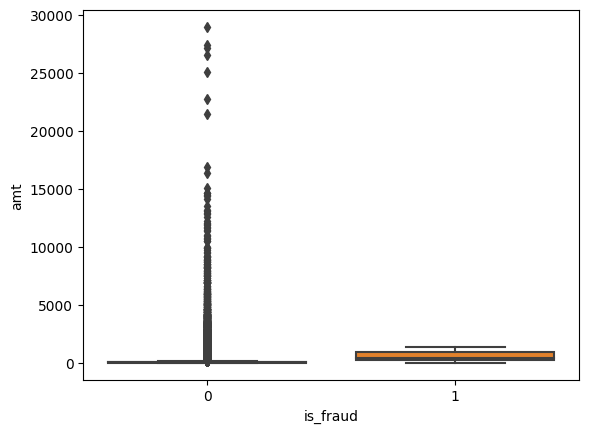

In [17]:
sns.boxplot(x="is_fraud", y="amt", data=train)

<Axes: xlabel='is_fraud', ylabel='amt'>

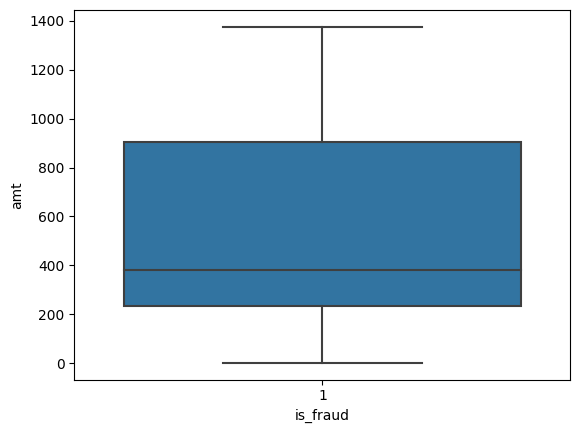

In [18]:
# getting a closer look at the fraudulent transactions
train_fraudulent = train[train["is_fraud"] == 1]
sns.boxplot(x="is_fraud", y="amt", data=train_fraudulent)

<Axes: xlabel='amt', ylabel='Count'>

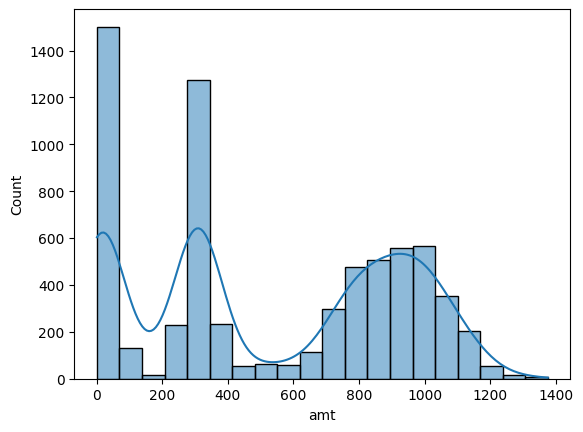

In [19]:
# create histogram to visualize the mode for fraudulent transactions
sns.histplot(train_fraudulent["amt"], kde=True)

Lower threshold:  -99.78
Upper threshold:  191.89999999999998
Number of data points removed: 62576
Percentage of data points removed: 0.04850988089590097


<Axes: xlabel='is_fraud', ylabel='amt'>

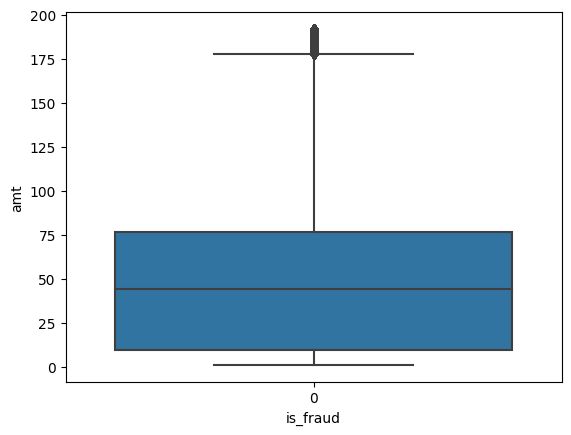

In [20]:
# remove outliers for non-fraudulent transactions to visualize histogram better
train_non_fraudulent = train[train["is_fraud"] == 0]

# calculate IQR and threshold values
IQR_train_non_fraudulent = np.percentile(train_non_fraudulent["amt"], 75) - np.percentile(train_non_fraudulent["amt"], 25)
lower_threshold = np.percentile(train_non_fraudulent["amt"], 25) - 1.5 * IQR_train_non_fraudulent
upper_threshold = np.percentile(train_non_fraudulent["amt"], 75) + 1.5 * IQR_train_non_fraudulent

# filter out data points outside threshold
train_non_fraudulent_without_outliers = train_non_fraudulent[train_non_fraudulent["amt"] <= upper_threshold]

print("Lower threshold: ", lower_threshold)
print("Upper threshold: ", upper_threshold)
print("Number of data points removed:", len(train_non_fraudulent) - len(train_non_fraudulent_without_outliers))
print("Percentage of data points removed:", (len(train_non_fraudulent) - len(train_non_fraudulent_without_outliers))/len(train_non_fraudulent))

sns.boxplot(x="is_fraud", y="amt", data=train_non_fraudulent_without_outliers)

Approximately 5% of data points of non-fraudulent transactions are outliers.

<Axes: xlabel='amt', ylabel='Count'>

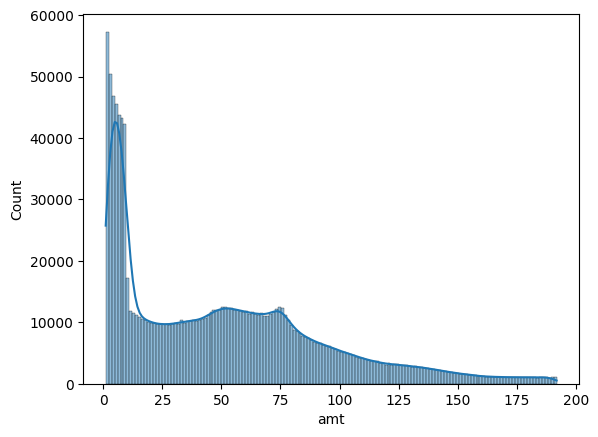

In [21]:
# create histogram to visualize the mode for non-fraudulent transactions, after outliers are removed
sns.histplot(train_non_fraudulent_without_outliers["amt"], kde=True)


Mean, median and mode amount of non-fraudulent transactions are much lower than that of fraudulent transactions.

Quantile Analysis

In [22]:
quantile = train[numerical_variables].describe().loc[['min', '25%', '50%', '75%', 'max']].transpose()
quantile.columns = ['min', 'Q1', 'Q2', 'Q3', 'max']
quantile['range'] = quantile['max'] - quantile['min']
quantile['IQR'] = quantile['Q3'] - quantile['Q1']
quantile

,min,Q1,Q2,Q3,max,range,IQR
cc_num,6.041621e+10,1.800429e+14,3.521417e+15,4.642255e+15,4.992346e+18,4.992346e+18,4.462213e+15
amt,1.000000e+00,9.630000e+00,4.741000e+01,8.304000e+01,2.894890e+04,2.894790e+04,7.341000e+01
zip,1.257000e+03,2.623700e+04,4.817400e+04,7.201100e+04,9.992100e+04,9.866400e+04,4.577400e+04
lat,2.002710e+01,3.466890e+01,3.935430e+01,4.194040e+01,6.669330e+01,4.666620e+01,7.271500e+00
long,-1.656723e+02,-9.679800e+01,-8.747690e+01,-8.017520e+01,-6.795030e+01,9.772200e+01,1.662280e+01
city_pop,2.300000e+01,7.410000e+02,2.435000e+03,2.032800e+04,2.906700e+06,2.906677e+06,1.958700e+04
unix_time,1.325376e+09,1.342999e+09,1.357093e+09,1.374592e+09,1.388534e+09,6.315832e+07,3.159306e+07
merch_lat,1.902779e+01,3.474414e+01,3.936965e+01,4.195856e+01,6.751027e+01,4.848248e+01,7.214427e+00
merch_long,-1.666712e+02,-9.690138e+01,-8.744308e+01,-8.024942e+01,-6.695090e+01,9.972034e+01,1.665196e+01
is_fraud,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00


In [23]:
descriptive_stats = train[numerical_variables].describe().loc[['mean', 'std', '50%']].transpose()
descriptive_stats.columns = ['mean', 'std', 'median']
descriptive_stats['mode'] = train[numerical_variables].mode().transpose()[0]
descriptive_stats['mad'] = [stats.median_abs_deviation(train[x]) for x in numerical_variables]
descriptive_stats['kurtosis'] = [stats.kurtosis(train[x]) for x in numerical_variables]
descriptive_stats['skewness'] = [stats.skew(train[x]) for x in numerical_variables]

descriptive_stats

,mean,std,median,mode,mad,kurtosis,skewness
cc_num,4.176007e+17,1.309380e+18,3.521417e+15,4.642255e+15,3.076471e+15,6.168762,2.849939
amt,7.008490e+01,1.628042e+02,4.741000e+01,1.140000e+00,3.743000e+01,4745.821264,44.083100
zip,4.881636e+04,2.687663e+04,4.817400e+04,4.808800e+04,2.305800e+04,-1.095226,0.078953
lat,3.854065e+01,5.070134e+00,3.935430e+01,4.251640e+01,3.359700e+00,0.793040,-0.193119
long,-9.023144e+01,1.374897e+01,-8.747690e+01,-8.298320e+01,8.152700e+00,1.837713,-1.147256
city_pop,8.836546e+04,3.010802e+05,2.435000e+03,6.060000e+02,2.180000e+03,37.778840,5.606287
unix_time,1.358677e+09,1.820237e+07,1.357093e+09,1.381002e+09,1.580185e+07,-1.200275,-0.019366
merch_lat,3.854014e+01,5.104269e+00,3.936965e+01,3.384919e+01,3.386277e+00,0.775896,-0.189130
merch_long,-9.023124e+01,1.376077e+01,-8.744308e+01,-9.651176e+01,8.220304e+00,1.831452,-1.144245
is_fraud,5.175545e-03,7.175488e-02,0.000000e+00,0.000000e+00,0.000000e+00,188.221564,13.792083


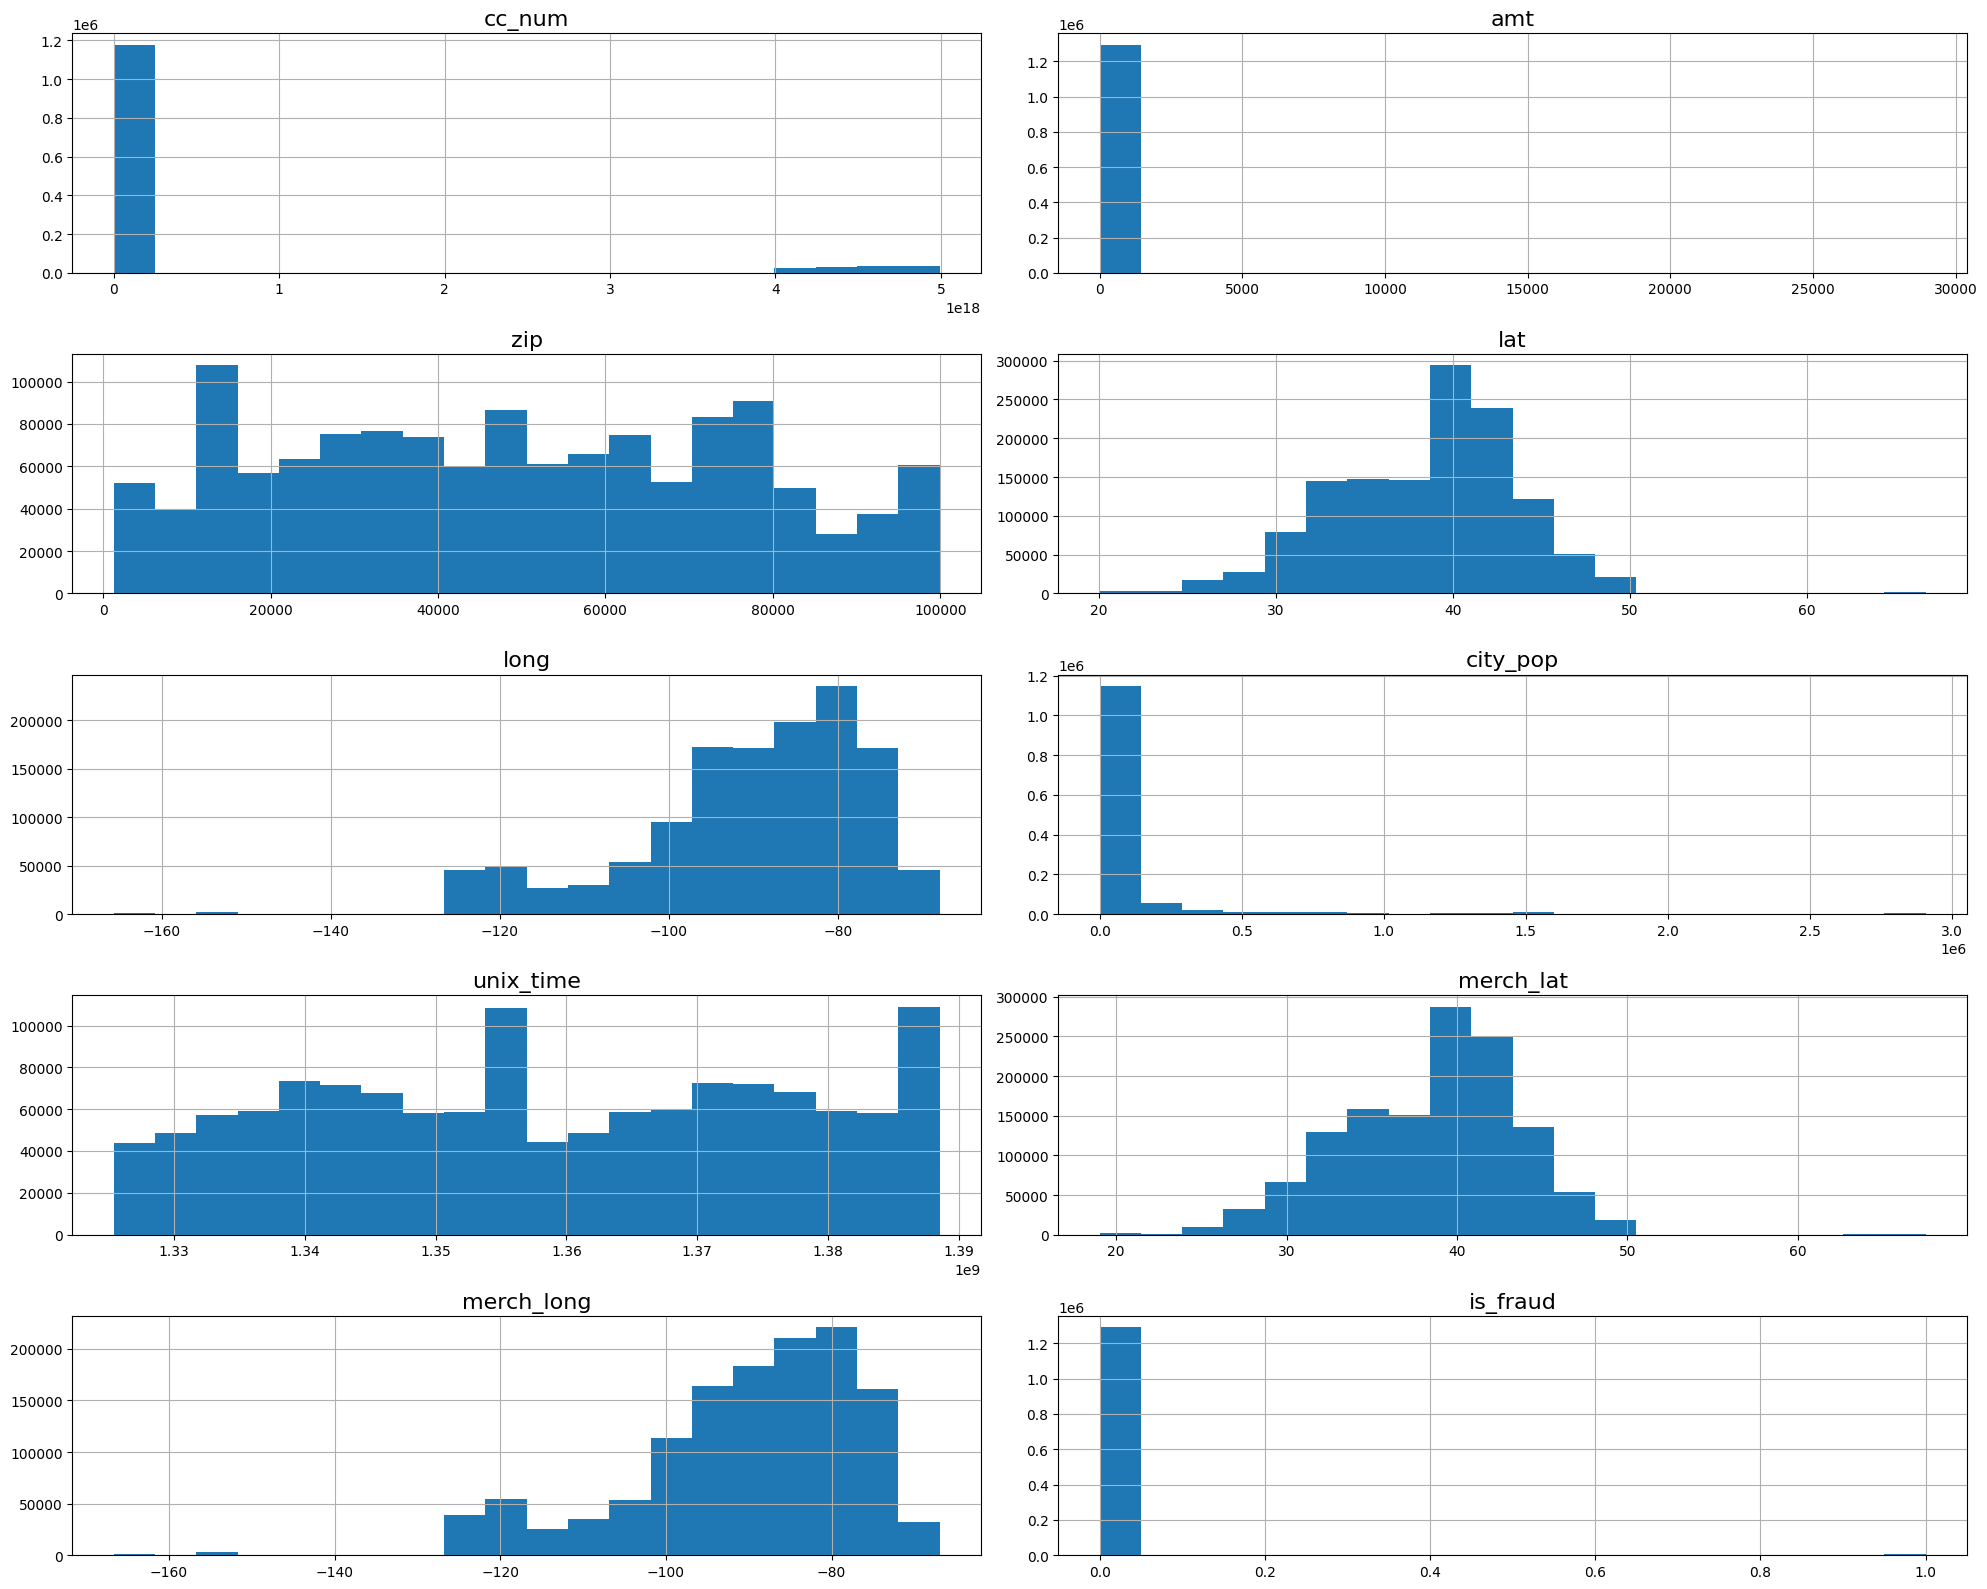

In [24]:
fig, axs = plt.subplots(5, 2, figsize=(20, 16))

axes = [None] * len(numerical_variables)

for index, name in enumerate(train[numerical_variables].columns):
    axes[index] = axs[index//2, index%2]
    train[name].hist(ax=axes[index], bins=20)
    axes[index].set_title(name, fontsize=16)

plt.tight_layout()
plt.show()

In [25]:
# f, axes = plt.subplots(6, 2, figsize=(16, 24), sharex=False)

# for index, name in enumerate(cat_variables):
#     sns.countplot(x=name, data=train, ax=axes[index//2,index%2])
#     axes[index//2,index%2].set_title(name, fontsize=20)
#     axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
    
# plt.tight_layout()
#Don't run this unless you have hours to spare, it has to count over a million observations for 11 different categorical variables,
#some of which have only unique values

print(len(train))

1296675


[Text(0, 0, 'shopping_net'),
 Text(1, 0, 'gas_transport'),
 Text(2, 0, 'home'),
 Text(3, 0, 'health_fitness'),
 Text(4, 0, 'grocery_pos'),
 Text(5, 0, 'misc_pos'),
 Text(6, 0, 'travel'),
 Text(7, 0, 'misc_net'),
 Text(8, 0, 'grocery_net'),
 Text(9, 0, 'food_dining'),
 Text(10, 0, 'shopping_pos'),
 Text(11, 0, 'entertainment'),
 Text(12, 0, 'kids_pets'),
 Text(13, 0, 'personal_care')]

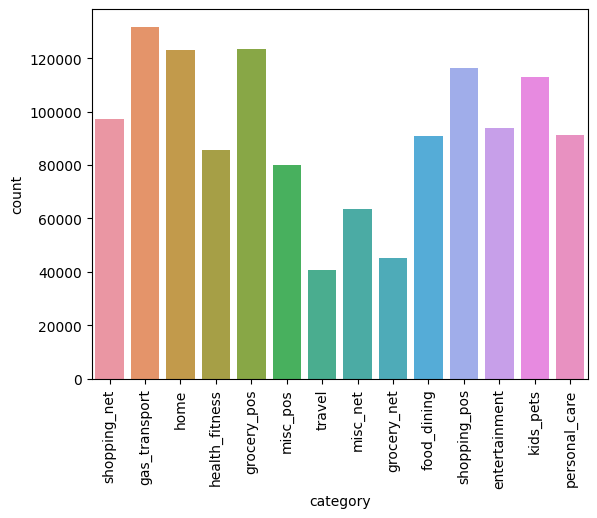

In [26]:
# sort train data by category
ax = sns.countplot(x="category", data=train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Text(0.5, 1.0, 'The Percentage Difference of Fraudulent over Non-Fraudulent Transations in Each Spending Category ')

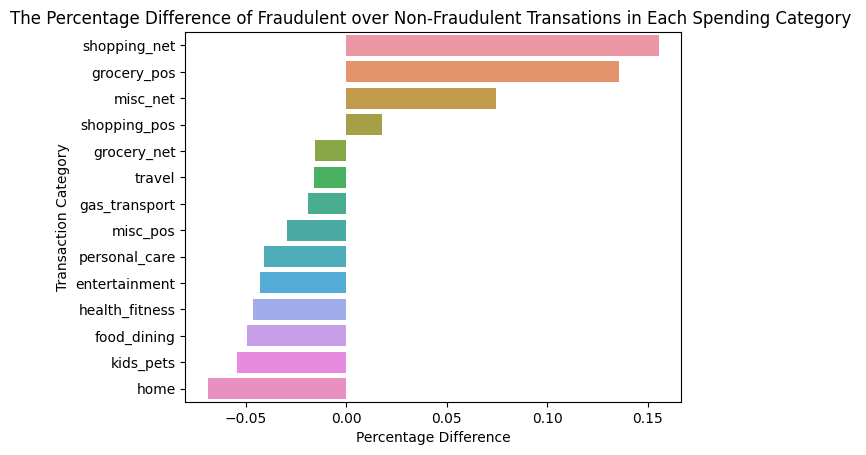

In [42]:
#calculate the percentage difference
a=train[train['is_fraud']==0]['category'].value_counts(normalize=True).to_frame().reset_index()
a.columns=['category','not fraud percentage']

b=train[train['is_fraud']==1]['category'].value_counts(normalize=True).to_frame().reset_index()
b.columns=['category','fraud percentage']
ab=a.merge(b,on='category')
ab['diff']=ab['fraud percentage']-ab['not fraud percentage']

ax=sns.barplot(y='category',x='diff',data=ab.sort_values('diff',ascending=False))
ax.set_xlabel('Percentage Difference')
ax.set_ylabel('Transaction Category')
plt.title('The Percentage Difference of Fraudulent over Non-Fraudulent Transations in Each Spending Category ')

Certain categories of spending are more susceptible to fraud, particularly 'Shopping_net', 'Grocery_pos', and 'misc_net'. Conversely, categories such as 'home' and 'kids_pets' generally experience higher volumes of legitimate transactions compared to fraudulent activity.

Text(0.5, 1.0, 'Non-Fraudulent Transactions')

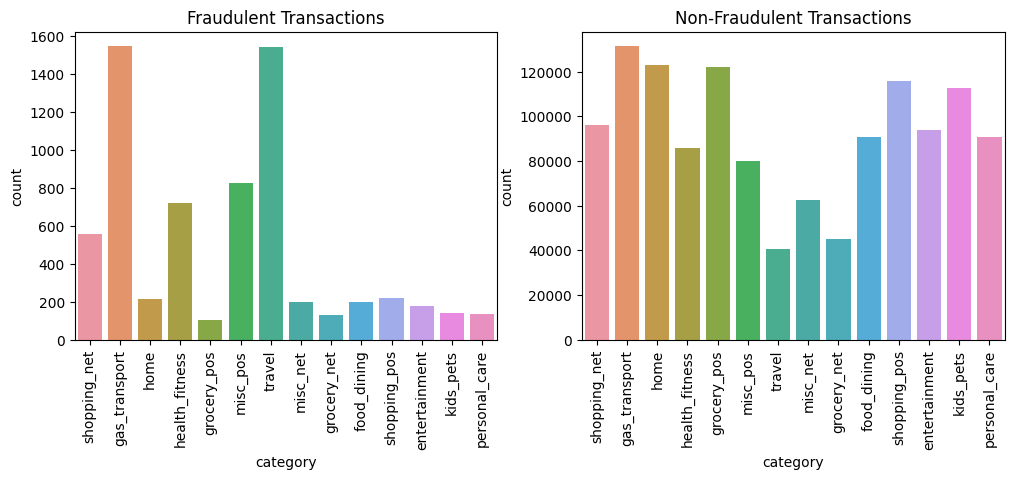

In [27]:
# sort fraudulent and non-fraudulent train data by category
fig, axes = plt.subplots(1, 2, figsize=(12, 4))


ax_fraudulent = sns.countplot(x="category", data=train_fraudulent, ax=axes[0])
ax_fraudulent.set_xticklabels(ax.get_xticklabels(), rotation=90)
axes[0].set_title("Fraudulent Transactions")

ax_non_fraudulent = sns.countplot(x="category", data=train_non_fraudulent, ax=axes[1])
ax_non_fraudulent.set_xticklabels(ax.get_xticklabels(), rotation=90)
axes[1].set_title("Non-Fraudulent Transactions")

#ax_non_fraudulent_without_outliers = sns.countplot(x="category", data=train_non_fraudulent_without_outliers, ax=axes[2])
#ax_non_fraudulent_without_outliers.set_xticklabels(ax.get_xticklabels(), rotation=90) 



From the above countplots we can see that among fraudulent transactions, gas_transport and travel have much higher occurrences compared to the other categories.

(KIV: help me see if this is correct)

In [28]:
# One-hot encode 'category' and keep the original column
category_dummies_train = pd.get_dummies(train['category'], prefix='category', dtype=int)
train = pd.concat([train, category_dummies_train], axis=1)

category_dummies_test = pd.get_dummies(test['category'], prefix='category', dtype=int)
test = pd.concat([test, category_dummies_test], axis=1)

# Assuming 'transaction_day_of_week' is a column derived from 'transaction_dt' indicating the day of the week
day_of_week_dummies_train = pd.get_dummies(train['transaction_day_of_week'], dtype=int)
train = pd.concat([train, day_of_week_dummies_train], axis=1)

day_of_week_dummies_test = pd.get_dummies(test['transaction_day_of_week'], dtype=int)
test = pd.concat([test, day_of_week_dummies_test], axis=1)


Text(0.5, 1.0, 'The Percentage of Fraudulent over Non-Fraudulent Transcations in Each State')

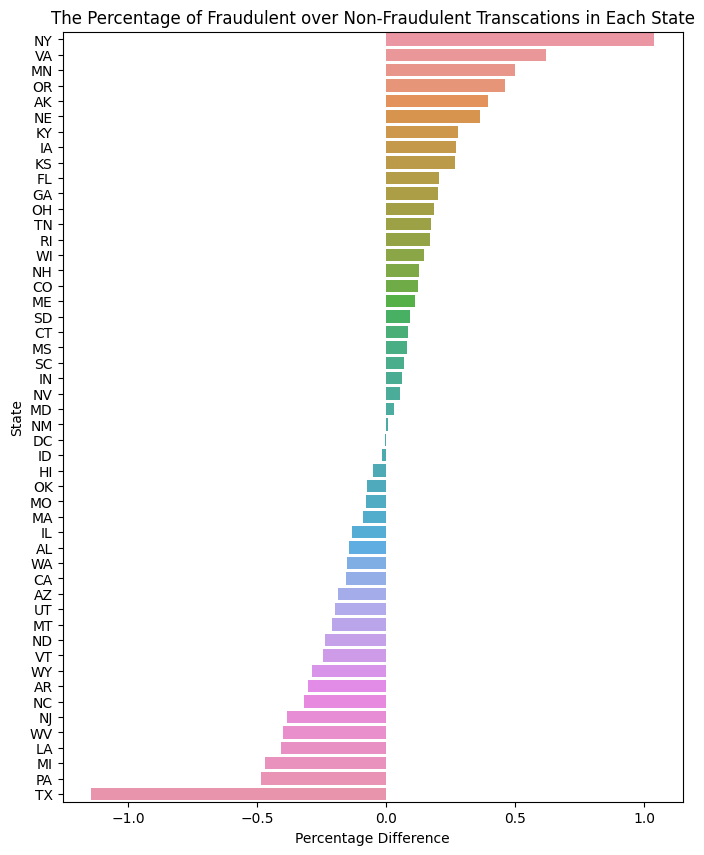

In [49]:
a=train['state'][train.is_fraud==0].value_counts(normalize=True)
a=a.to_frame()
a=a.reset_index()
a.columns = ['State', 'Per']

b=train['state'][train.is_fraud==1].value_counts(normalize=True)
b=b.to_frame()
b=b.reset_index()
b.columns = ['State', 'Per']
merged=a.merge(b,on='State')
merged['diff']=merged['Per_y']-merged['Per_x']
merged['diff']=merged['diff']*100
merged=merged.sort_values('diff',ascending=False)

plt.figure(figsize=(8, 10))
ax1=sns.barplot(data=merged, x='diff',y='State')
ax1.set_xlabel('Percentage Difference')
ax1.set_ylabel('State')
plt.title('The Percentage of Fraudulent over Non-Fraudulent Transcations in Each State')

It's observable that states like NY and OH, among others, exhibit a higher proportion of fraudulent transactions as opposed to legitimate ones, in contrast to states like TX and MT, which show the reverse trend. Nonetheless, it's worth noting that the percentage variances in these states are relatively modest, indicating a correlation, albeit not a strong one.

In [29]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 456136 to 305711
Data columns (total 47 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   trans_date_trans_time    1296675 non-null  object        
 1   cc_num                   1296675 non-null  int64         
 2   merchant                 1296675 non-null  object        
 3   category                 1296675 non-null  object        
 4   amt                      1296675 non-null  float64       
 5   first                    1296675 non-null  object        
 6   last                     1296675 non-null  object        
 7   gender                   1296675 non-null  object        
 8   street                   1296675 non-null  object        
 9   city                     1296675 non-null  object        
 10  state                    1296675 non-null  object        
 11  zip                      1296675 non-null  int64         
 12  l

Text(0.5, 1.0, 'Non-Fraudulent Transactions')

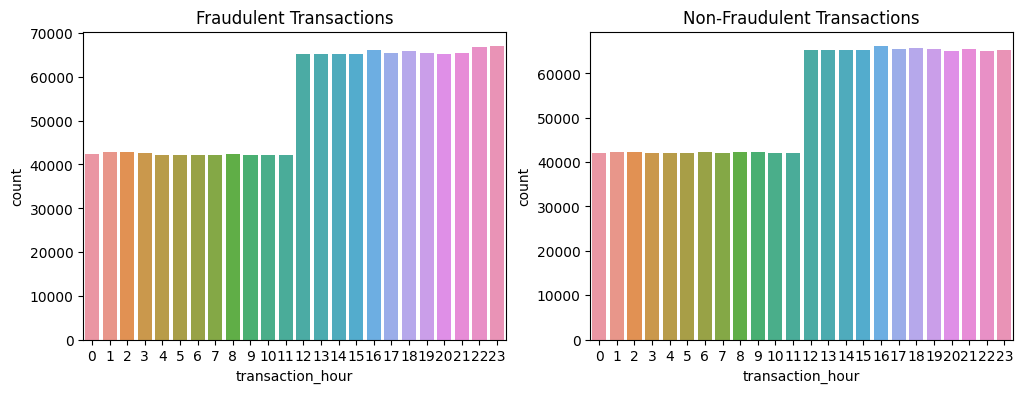

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax_fraudulent = sns.countplot(x="transaction_hour", data=train, ax=axes[0])
axes[0].set_title("Fraudulent Transactions")

ax_non_fraudulent = sns.countplot(x="transaction_hour", data=train_non_fraudulent, ax=axes[1])
axes[1].set_title("Non-Fraudulent Transactions")

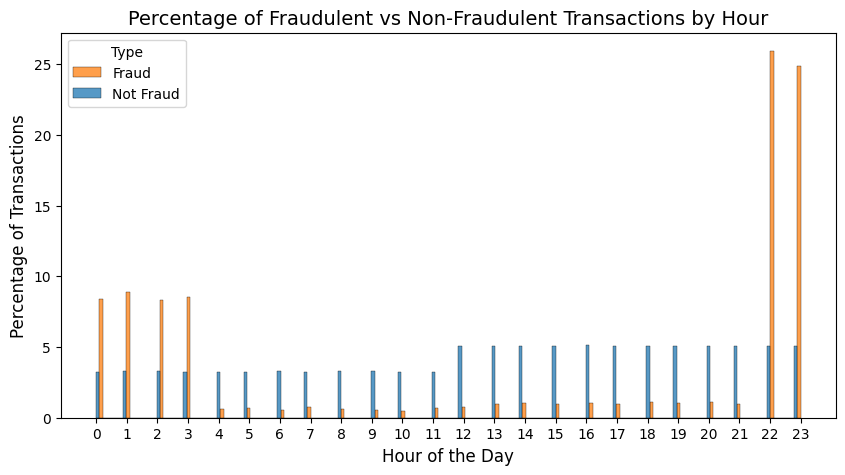

In [62]:
plt.figure(figsize=(10, 5))
ax=sns.histplot(data=train, x="transaction_hour", hue="is_fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage of Transactions', fontsize=12)
ax.set_xlabel('Hour of the Day', fontsize=12)
ax.set_title('Percentage of Fraudulent vs Non-Fraudulent Transactions by Hour', fontsize=14)

plt.xticks(np.arange(0,24,1))
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])
plt.show()

 Fraudulent transactions happen around midnight when most people are asleep


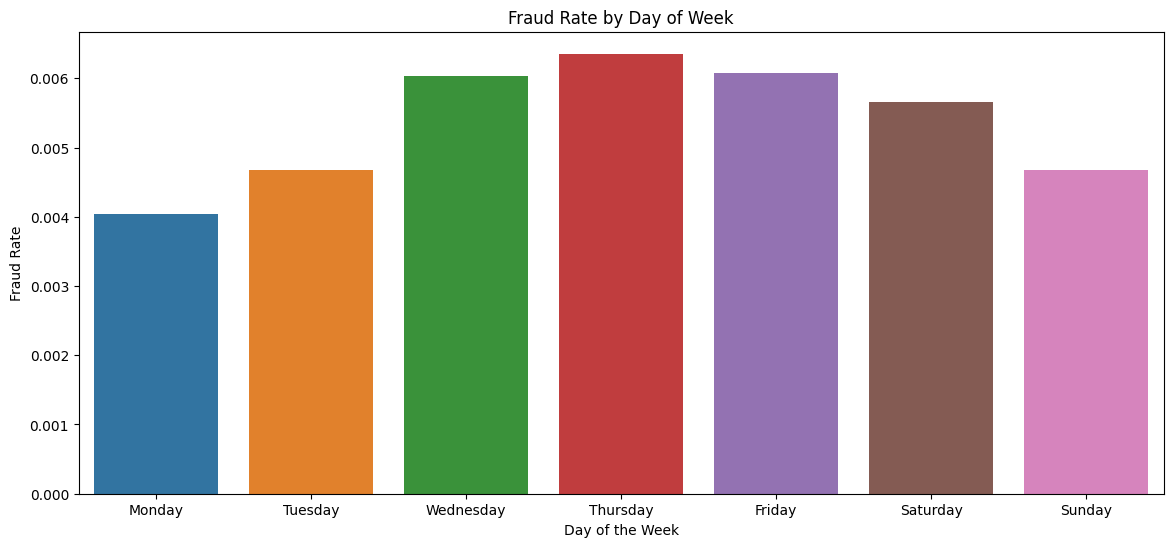

In [50]:
# Calculate the fraud rate
fraud_rate = (train[train['is_fraud'] == 1].groupby('transaction_day_of_week').size() / 
              train.groupby('transaction_day_of_week').size())

# Convert to DataFrame for plotting
fraud_rate = fraud_rate.reset_index(name='fraud_rate')

# Plot the fraud rates by day of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(14, 6))
sns.barplot(x='transaction_day_of_week', y='fraud_rate', data=fraud_rate, order=days_order)
plt.title('Fraud Rate by Day of Week')
plt.xlabel('Day of the Week')
plt.ylabel('Fraud Rate')
plt.show()


Some conclusions that can be drawn:
- Fraudulent transactions are usually higher amounted (probably the most useful)
- Fraudulent transactions are more likely to be done between 2200-0400H
- Fraudulent transactions are more likely to be under transportation merchants or travel merchants
- 

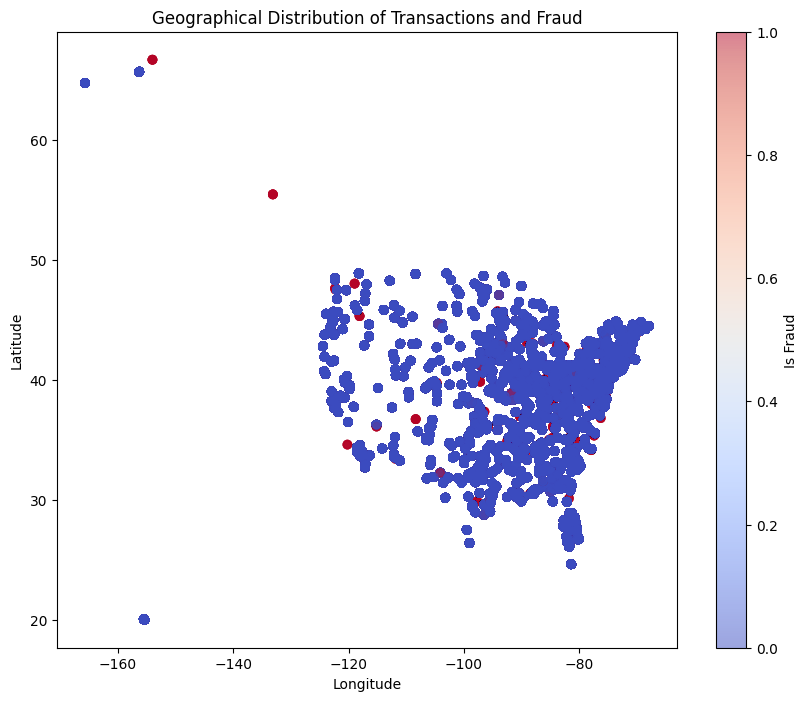

In [32]:
# Scatter plot of geographical data
plt.figure(figsize=(10, 8))
plt.scatter(train['long'], train['lat'], c=train['is_fraud'], cmap='coolwarm', alpha=0.5)
plt.title('Geographical Distribution of Transactions and Fraud')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Is Fraud')
plt.show()

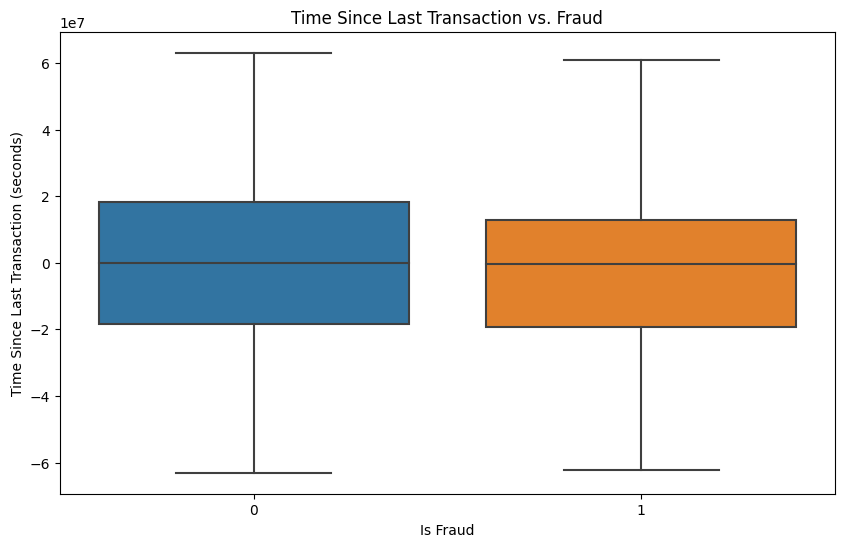

In [38]:
# Transaction Velocity Analysis
train['time_since_last_transaction'] = train.groupby('cc_num')['unix_time'].diff()
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='time_since_last_transaction', data=train)
plt.title('Time Since Last Transaction vs. Fraud')
plt.xlabel('Is Fraud')
plt.ylabel('Time Since Last Transaction (seconds)')
plt.show()

In [39]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 456136 to 305711
Data columns (total 48 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   trans_date_trans_time        1296675 non-null  object        
 1   cc_num                       1296675 non-null  int64         
 2   merchant                     1296675 non-null  object        
 3   category                     1296675 non-null  object        
 4   amt                          1296675 non-null  float64       
 5   first                        1296675 non-null  object        
 6   last                         1296675 non-null  object        
 7   gender                       1296675 non-null  object        
 8   street                       1296675 non-null  object        
 9   city                         1296675 non-null  object        
 10  state                        1296675 non-null  object        
 11  zip         

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Define the columns to drop
all_columns_to_drop = [
    'trans_date_trans_time', 'cc_num', 'first', 'last', 'street',
    'merchant', 'city', 'job', 'dob', 'transaction_dt', 'lat', 'long',
    'merch_lat', 'merch_long', 'zip', 'category', 'transaction_day_of_week', 
    'gender', 'state', 'trans_num'
]

# Drop the columns from the training set
X_train_log = train.drop(columns=all_columns_to_drop, axis=1, errors='ignore')
y_train_log = train['is_fraud']

# Drop the columns from the test set
X_test_log = test.drop(columns=all_columns_to_drop, axis=1, errors='ignore')
y_test_log = test['is_fraud']

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')

# Fit the model on the training data
log_reg.fit(X_train_log, y_train_log)

# Predict on the test set
y_pred_log = log_reg.predict(X_test_log)

# Evaluate the model's performance
print(classification_report(y_test_log, y_pred_log))


c:\Users\leejw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leejw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00    184279
           1       0.00      0.00      0.00       960

    accuracy                           0.99    185239
   macro avg       0.50      0.50      0.50    185239
weighted avg       0.99      0.99      0.99    185239



c:\Users\leejw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Didnt predict any frauds LOL

In [35]:
print(X_train_log.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 456136 to 305711
Data columns (total 27 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   amt                      1296675 non-null  float64
 1   city_pop                 1296675 non-null  int64  
 2   unix_time                1296675 non-null  int64  
 3   is_fraud                 1296675 non-null  int64  
 4   transaction_hour         1296675 non-null  int32  
 5   age                      1296675 non-null  int32  
 6   category_entertainment   1296675 non-null  int32  
 7   category_food_dining     1296675 non-null  int32  
 8   category_gas_transport   1296675 non-null  int32  
 9   category_grocery_net     1296675 non-null  int32  
 10  category_grocery_pos     1296675 non-null  int32  
 11  category_health_fitness  1296675 non-null  int32  
 12  category_home            1296675 non-null  int32  
 13  category_kids_pets       1296675 non-null  

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Define the columns to drop
all_columns_to_drop = [
    'trans_date_trans_time', 'cc_num', 'first', 'last', 'street',
    'merchant', 'city', 'job', 'dob', 'transaction_dt', 'lat', 'long',
    'merch_lat', 'merch_long', 'zip', 'category', 'transaction_day_of_week', 
    'gender', 'state', 'trans_num'
]

# Drop the columns from the training set
X_train_tree = train.drop(columns=all_columns_to_drop + ['is_fraud'], axis=1, errors='ignore')
y_train_tree = train['is_fraud']

# Drop the columns from the test set
X_test_tree = test.drop(columns=all_columns_to_drop + ['is_fraud'], axis=1, errors='ignore')
y_test_tree = test['is_fraud']

# Initialize the Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Fit the model on the training data
decision_tree.fit(X_train_tree, y_train_tree)

# Predict on the test set
y_pred_tree = decision_tree.predict(X_test_tree)

# Evaluate the model's performance
print(classification_report(y_test_tree, y_pred_tree))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    184279
           1       0.80      0.80      0.80       960

    accuracy                           1.00    185239
   macro avg       0.90      0.90      0.90    185239
weighted avg       1.00      1.00      1.00    185239



In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Fit the model on the training data
random_forest.fit(X_train_tree, y_train_tree)

# Predict on the test set
y_pred_rf = random_forest.predict(X_test_tree)

# Evaluate the model's performance
print(classification_report(y_test_tree, y_pred_rf))


KeyboardInterrupt: 

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid for Random Forest
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Initialize the GridSearchCV object
# grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
#                            param_grid=param_grid, 
#                            cv=3, 
#                            n_jobs=-1, 
#                            verbose=2,
#                            scoring='roc_auc')

# # Fit the grid search to the data
# grid_search.fit(X_train_tree, y_train_tree)

# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)

# # Train the model with the best parameters
# best_random_forest = RandomForestClassifier(**best_params, random_state=42)
# best_random_forest.fit(X_train_tree, y_train_tree)

# # Predict on the test set
# y_pred_best_rf = best_random_forest.predict(X_test_tree)

# # Evaluate the best model's performance
# print(classification_report(y_test_tree, y_pred_best_rf))


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting Classifier
gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
gradient_boosting.fit(X_train_tree, y_train_tree)

# Predict on the test set
y_pred_gb = gradient_boosting.predict(X_test_tree)

# Evaluate the model's performance
print(classification_report(y_test_tree, y_pred_gb))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    184279
           1       0.84      0.69      0.76       960

    accuracy                           1.00    185239
   macro avg       0.92      0.85      0.88    185239
weighted avg       1.00      1.00      1.00    185239



In [2]:
import pandas as pd
import networkx as nx

def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    mapping = {x:node_id for node_id, x in enumerate(set(df["cc_num"].values.tolist() + df["merchant"].values.tolist()))}
    df["from"] = df["cc_num"].apply(lambda x: mapping[x])
    df["to"] = df["merchant"].apply(lambda x: mapping[x])
    df = df[['from', 'to', 'amt', 'is_fraud']].groupby(['from', 'to']).agg({'is_fraud': 'sum', 'amt': 'sum'}).reset_index()
    df['is_fraud'] = df['is_fraud'].apply(lambda x: 1 if x>0 else 0)
    
    G = nx.from_edgelist(df[['from', 'to']].values, create_using=graph_type)
    
    nx.set_node_attributes(G, {x:1 for x in df['from'].unique()}, "bipartite")
    nx.set_node_attributes(G, {x:2 for x in df['to'].unique()}, "bipartite")
    
    nx.set_edge_attributes(G,
                           {(int(x['from']), int(x['to'])): x['is_fraud'] for idx, x in df[['from', 'to', 'is_fraud']].iterrows()},
                           "label")
    
    nx.set_edge_attributes(G,
                           {(int(x['from']), int(x['to'])): x['amt'] for idx, x in df[['from', 'to', 'amt']].iterrows()},
                           "weight")
    
    return G


In [3]:
import pandas as pd
import networkx as nx

def build_graph_tripartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    mapping = {x: node_id for node_id, x in enumerate(set(df.index.values.tolist() +
                                                          df["cc_num"].values.tolist() +
                                                          df["merchant"].values.tolist()))}
    df["in_node"] = df["cc_num"].apply(lambda x: mapping[x])
    df["out_node"] = df["merchant"].apply(lambda x: mapping[x])

    G = nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +
                         [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()],
                         create_using=graph_type)

    nx.set_node_attributes(G, {x["in_node"]: 1 for idx, x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G, {x["out_node"]: 2 for idx, x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G, {mapping[idx]: 3 for idx, x in df.iterrows()}, "bipartite")

    nx.set_edge_attributes(G, {(x["in_node"], mapping[idx]): x["is_fraud"] for idx, x in df.iterrows()}, "label")
    nx.set_edge_attributes(G, {(x["out_node"], mapping[idx]): x["is_fraud"] for idx, x in df.iterrows()}, "label")

    nx.set_edge_attributes(G, {(x["in_node"], mapping[idx]): x["amt"] for idx, x in df.iterrows()}, "weight")
    nx.set_edge_attributes(G, {(x["out_node"], mapping[idx]): x["amt"] for idx, x in df.iterrows()}, "weight")

    return G


In [9]:
G_bu = build_graph_bipartite(train, nx.Graph(name='Bipartite Undirected'))
G_bd = build_graph_bipartite(train, nx.DiGraph(name='Bipartite Directed'))
G_tu = build_graph_tripartite(train, nx.Graph(name='Tripartite Undirected'))
G_td = build_graph_tripartite(train, nx.DiGraph(name='Tripartite Directed'))


In [10]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(G_bu)

True

In [11]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(G_bd)

True

In [12]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(G_tu)

True

In [13]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(G_td)

True

In [17]:
print('Number of nodes', len(G_bu.nodes))
print('Number of edges', len(G_bu.edges))
print('Average degree', sum(dict(G_bu.degree).values()) / len(G_bu.nodes))

Number of nodes 1692
Number of edges 479199
Average degree 566.4290780141844


In [18]:
print('Number of nodes', len(G_tu.nodes))
print('Number of edges', len(G_tu.edges))
print('Average degree', sum(dict(G_tu.degree).values()) / len(G_tu.nodes))

Number of nodes 1298367
Number of edges 2593350
Average degree 3.994787298198429


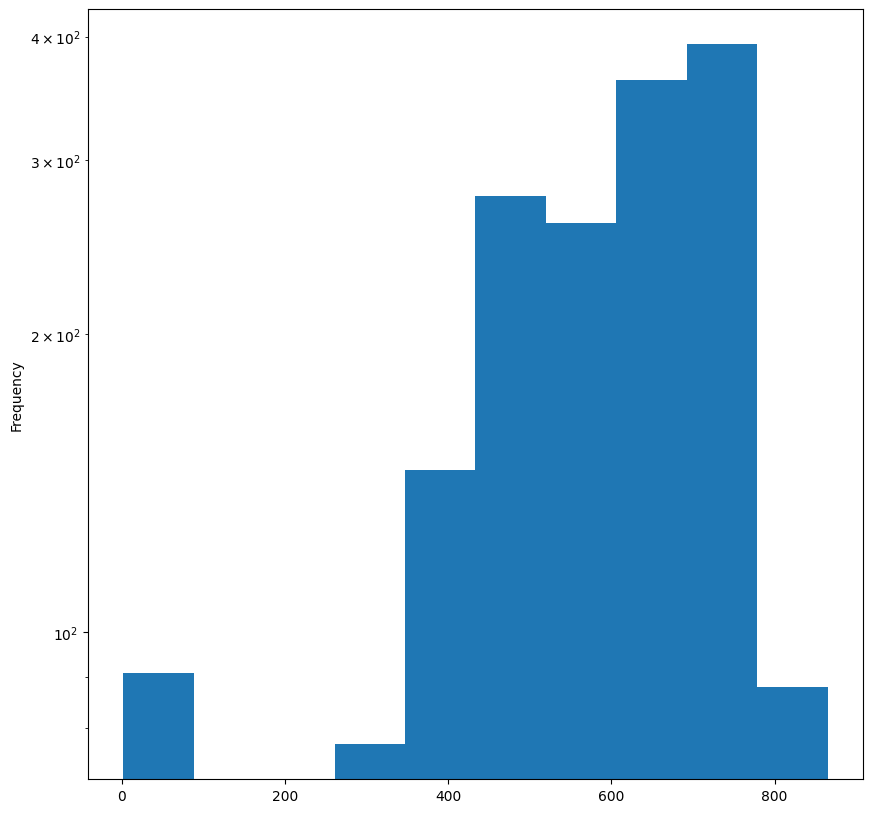

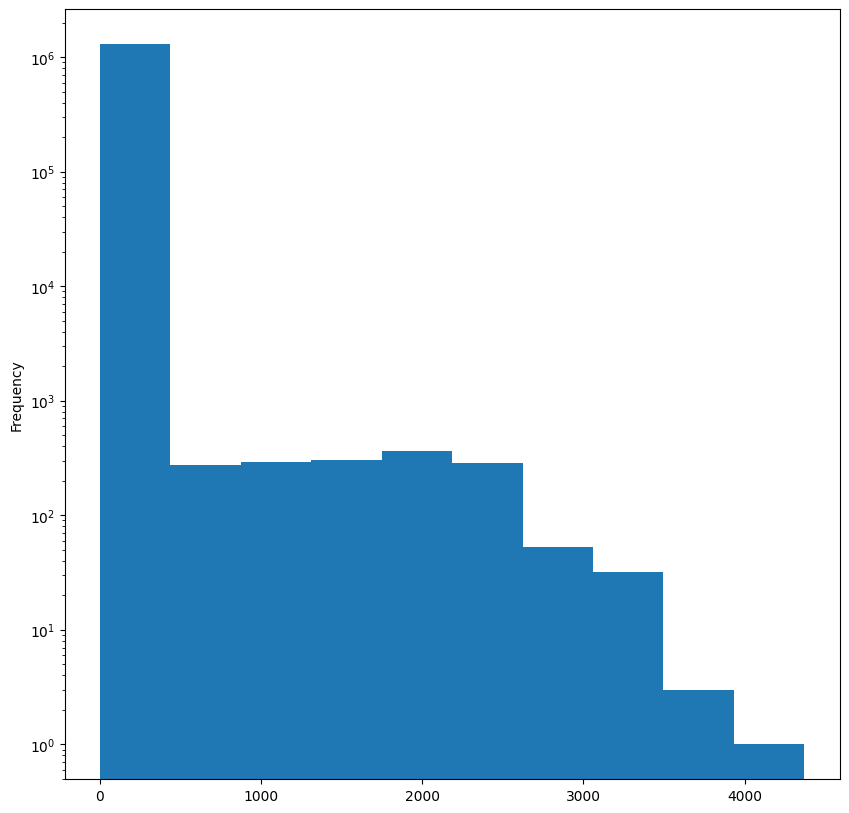

In [19]:
for G in [G_bu, G_tu]:
    plt.figure(figsize=(10,10))
    degrees = pd.Series(
        {
            k:v for k,v in nx.degree(G)
        }
    )
    degrees.plot.hist()
    plt.yscale("log")


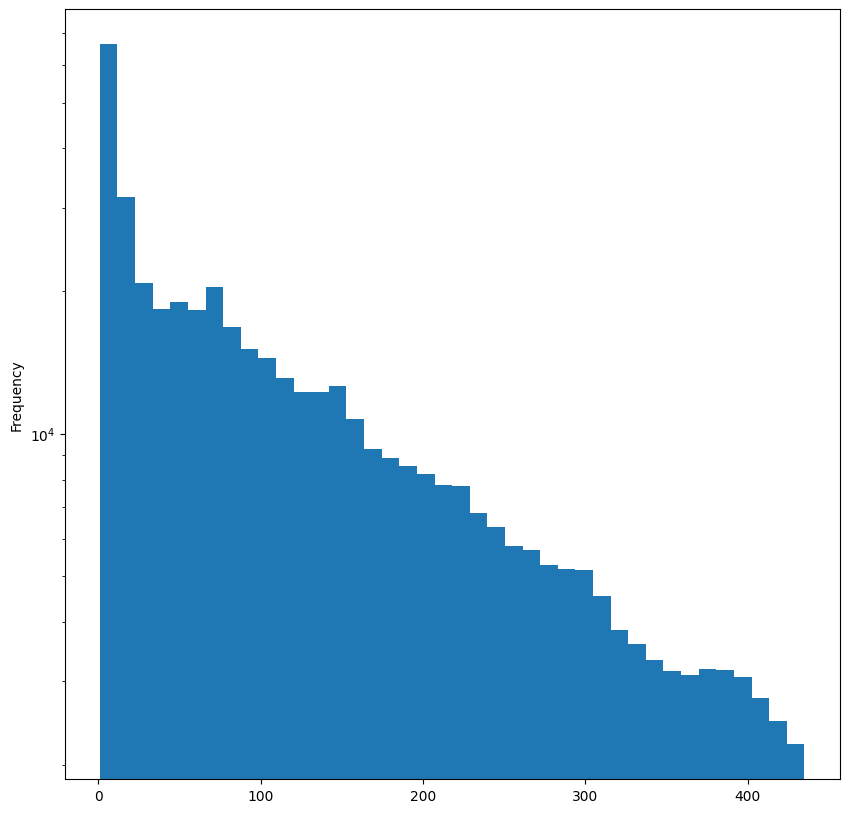

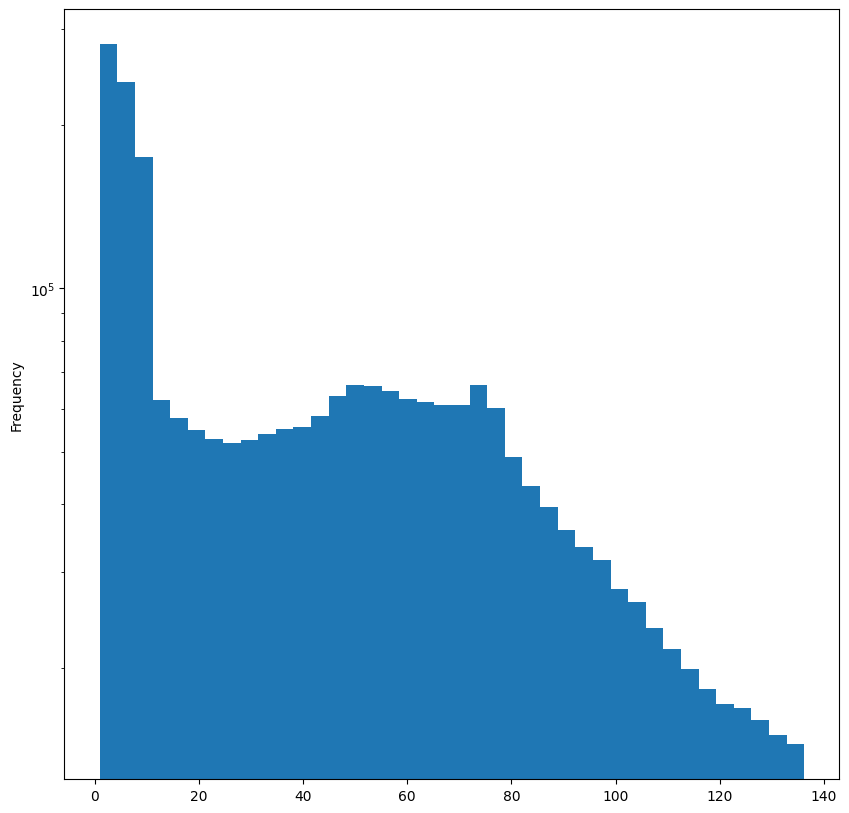

In [20]:
# Edge Weight Distribution

for G in [G_bu, G_tu]:
    allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True)})
    np.quantile(allEdgesWeights.values, [0.10, 0.50, 0.70, 0.9, 1.0])
    quant_dist = np.quantile(allEdgesWeights.values, [0.10, 0.50, 0.70, 0.9])
    allEdgesWeightsFiltered = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True) 
                                         if d[2]["weight"] < quant_dist[-1]})
    
    plt.figure(figsize=(10,10))
    allEdgesWeightsFiltered.plot.hist(bins=40)
    plt.yscale("log")


In [22]:
import community

parts = community.best_partition(G_bu, random_state=42, weight='weight')
communities = pd.Series(parts)
communities.value_counts().sort_values(ascending=False)


2    632
0    404
3    298
1    283
6     32
4     26
5     17
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

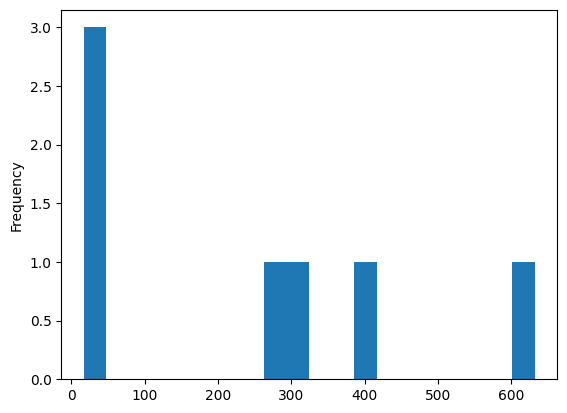

In [23]:
communities.value_counts().plot.hist(bins=20)

In [24]:
# Ratio of fraudulent / benign nodes in Communities Detected
graphs = []
d = {}

for x in communities.unique():
    tmp = nx.subgraph(G_bu, communities[communities == x].index)
    fraud_edges = sum(nx.get_edge_attributes(tmp, "label").values())
    ratio = 0 if fraud_edges == 0 else (fraud_edges/tmp.number_of_edges())*100
    d[x] = ratio
    graphs += [tmp]

pd.Series(d).sort_values(ascending=False)


5    27.027027
4    20.512821
6    12.096774
0     2.589367
1     2.293794
3     0.747545
2     0.743048
dtype: float64

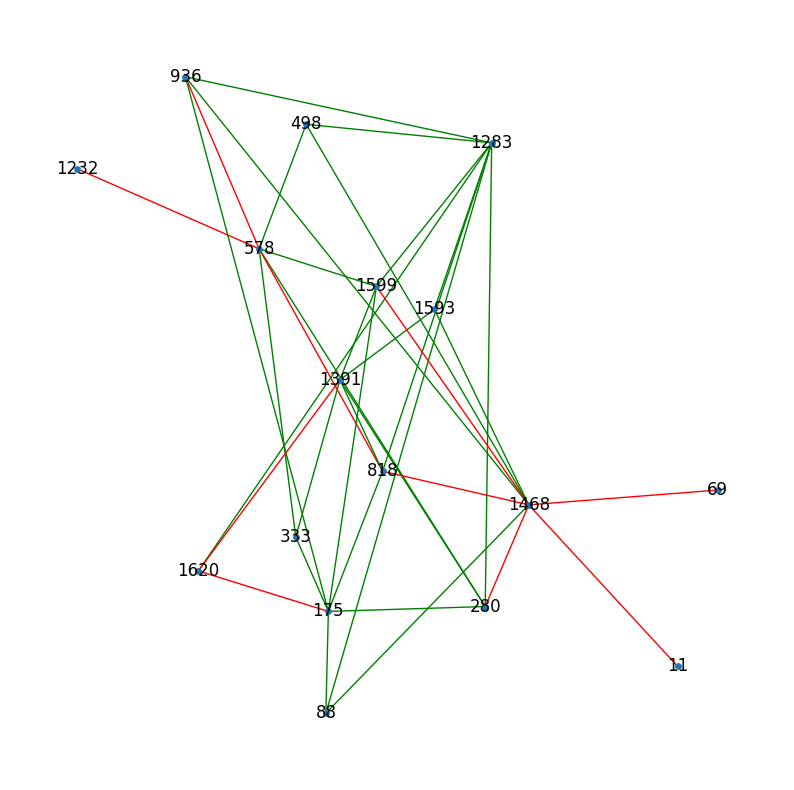

In [26]:
# Fraudulent Edges in each Community ID
gId = 5
plt.figure(figsize=(10,10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(graphs[gId], 'label').values()]
nx.draw_networkx(graphs[gId], pos=spring_pos,
                 edge_color=edge_colors, with_labels=True, node_size=15)


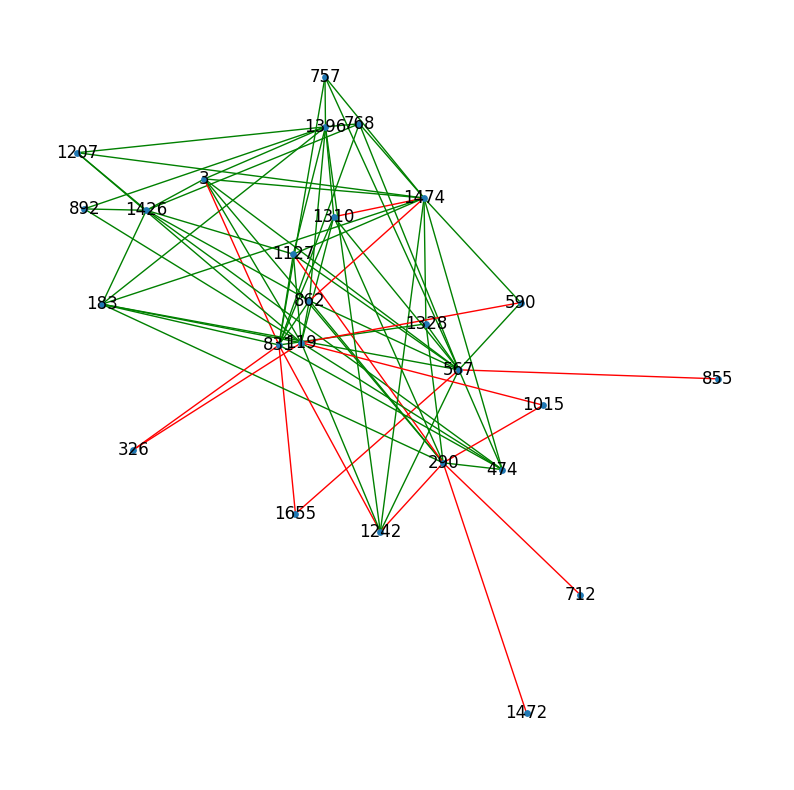

In [27]:
# Fraudulent Edges in each Community ID
gId = 4
plt.figure(figsize=(10,10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(graphs[gId], 'label').values()]
nx.draw_networkx(graphs[gId], pos=spring_pos,
                 edge_color=edge_colors, with_labels=True, node_size=15)
